In [1]:
# rm(list=ls())
require(data.table)
require(MASS)
require(ggplot2)
# require(foreach)
require(gridExtra)
require(stringr)
require(matrixStats)
require(parallel)
require(abind)

parallel::detectCores()
## Resizing notebook plot space
options(repr.plot.width=16, repr.plot.height=9)

Loading required package: data.table
Loading required package: MASS
Loading required package: ggplot2
Loading required package: gridExtra
Loading required package: stringr
Loading required package: matrixStats
Loading required package: parallel
Loading required package: abind


[1] 56

In [2]:
## POP DATA from UN
# pop <- data.table(fread("/home/j/Project/IRH/Forecasting/data/WPP_forecasted_population.csv"))
pop <- fread('/ihme/forecasting/data/pop/20150101_wpp/data.csv')
pop <- pop[, age_group_id:=15+5*(age_group_id -8)] 
pop<- pop[age_group_id == 15 | age_group_id == 20 | age_group_id == 25 | age_group_id == 30 | age_group_id == 35 | age_group_id == 40 | age_group_id == 45 | age_group_id == 50 | age_group_id == 55 | age_group_id == 60 | age_group_id == 65 | age_group_id == 70 | age_group_id == 75 | age_group_id == 85,]
head(pop)

location_id,sex_id,age_group_id,year_id,pop
6,1,15,1950,27530292
6,1,15,1951,28008975
6,1,15,1952,28183766
6,1,15,1953,28252474
6,1,15,1954,28303795
6,1,15,1955,28343730


In [3]:
## Education forecasts
# edu_orig<-data.table(fread(paste0("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/tabulated_data/archive_nafis/20161121_GBD2016prelim_95+_raked_2/gpr_draws.csv"), header = T))
# edu_orig <- edu_orig[, V1:=NULL]
# head(edu_orig)

edu_ref <- fread("/ihme/forecasting/data/fbd_scenarios_data/forecast/covariate/education/20170608_GBD2016Final/20170608_GBD2016Final_gpr_draws_scenario0.csv")
edu_pes <- fread("/ihme/forecasting/data/fbd_scenarios_data/forecast/covariate/education/20170608_GBD2016Final/20170608_GBD2016Final_gpr_draws_scenario-1.csv")
edu_opt <- fread("/ihme/forecasting/data/fbd_scenarios_data/forecast/covariate/education/20170608_GBD2016Final/20170608_GBD2016Final_gpr_draws_scenario1.csv")

Read 475800 rows and 1004 (of 1004) columns from 6.191 GB file in 00:02:06
Read 475800 rows and 1004 (of 1004) columns from 6.192 GB file in 00:02:28
Read 475800 rows and 1004 (of 1004) columns from 6.190 GB file in 00:02:30


In [4]:
## Convert age_group_id to age_start
  ## Leave out the younglings (no maternal education)    
    edu_ref <- edu_ref[age_group_id >7]
    edu_ref <- edu_ref[, age_group_id:=15+5*(age_group_id -8)] 
    
    edu_pes <- edu_pes[age_group_id >7]
    edu_pes <- edu_pes[, age_group_id:=15+5*(age_group_id -8)] 
    
    edu_opt <- edu_opt[age_group_id >7]
    edu_opt <- edu_opt[, age_group_id:=15+5*(age_group_id -8)] 

# edu_orig_2 <- edu_orig
## Merge pop for later stuff
# edu_orig_2 <- merge(edu_orig_2, pop, by = c("location_id", "year_id", "age_group_id", "sex_id"))
# head(edu_orig_2)

In [5]:
## How you lookin?
 head(edu_ref); head(edu_opt); head(edu_pes);

location_id,age_group_id,sex_id,year_id,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,⋯,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
6,15,1,1980,8.195544,7.856324,8.401491,9.273246,8.992329,8.964878,⋯,9.161543,8.760984,8.799634,7.828814,8.363295,8.391927,7.986652,8.969120,7.888389,8.868681
6,15,1,1981,8.147565,7.995990,8.300895,9.233780,9.023098,8.942048,⋯,9.096156,8.771453,8.835323,7.893521,8.456012,8.404336,8.119655,8.888441,7.918112,8.809835
6,15,1,1982,8.099316,8.128367,8.207957,9.189589,9.047270,8.918667,⋯,9.027742,8.785263,8.869407,7.953739,8.548425,8.412889,8.246784,8.807993,7.947025,8.759813
6,15,1,1983,8.052140,8.253047,8.123502,9.141470,9.065569,8.895725,⋯,8.957377,8.802851,8.903085,8.010255,8.640162,8.418698,8.368072,8.729619,7.975628,8.719149
6,15,1,1984,8.007288,8.369833,8.048323,9.090263,9.078829,8.874083,⋯,8.886159,8.824562,8.937524,8.063889,8.730709,8.422927,8.483543,8.655100,8.004449,8.688123
6,15,1,1985,7.965937,8.478749,7.983198,9.036858,9.087964,8.854468,⋯,8.815209,8.850664,8.973828,8.115483,8.819436,8.426788,8.593215,8.586134,8.034035,8.666778


location_id,age_group_id,sex_id,year_id,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,⋯,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
6,15,1,1980,8.195544,7.856324,8.401491,9.273246,8.992329,8.964878,⋯,9.161543,8.760984,8.799634,7.828814,8.363295,8.391927,7.986652,8.969120,7.888389,8.868681
6,15,1,1981,8.147565,7.995990,8.300895,9.233780,9.023098,8.942048,⋯,9.096156,8.771453,8.835323,7.893521,8.456012,8.404336,8.119655,8.888441,7.918112,8.809835
6,15,1,1982,8.099316,8.128367,8.207957,9.189589,9.047270,8.918667,⋯,9.027742,8.785263,8.869407,7.953739,8.548425,8.412889,8.246784,8.807993,7.947025,8.759813
6,15,1,1983,8.052140,8.253047,8.123502,9.141470,9.065569,8.895725,⋯,8.957377,8.802851,8.903085,8.010255,8.640162,8.418698,8.368072,8.729619,7.975628,8.719149
6,15,1,1984,8.007288,8.369833,8.048323,9.090263,9.078829,8.874083,⋯,8.886159,8.824562,8.937524,8.063889,8.730709,8.422927,8.483543,8.655100,8.004449,8.688123
6,15,1,1985,7.965937,8.478749,7.983198,9.036858,9.087964,8.854468,⋯,8.815209,8.850664,8.973828,8.115483,8.819436,8.426788,8.593215,8.586134,8.034035,8.666778


location_id,age_group_id,sex_id,year_id,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,⋯,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
6,15,1,1980,8.195544,7.856324,8.401491,9.273246,8.992329,8.964878,⋯,9.161543,8.760984,8.799634,7.828814,8.363295,8.391927,7.986652,8.969120,7.888389,8.868681
6,15,1,1981,8.147565,7.995990,8.300895,9.233780,9.023098,8.942048,⋯,9.096156,8.771453,8.835323,7.893521,8.456012,8.404336,8.119655,8.888441,7.918112,8.809835
6,15,1,1982,8.099316,8.128367,8.207957,9.189589,9.047270,8.918667,⋯,9.027742,8.785263,8.869407,7.953739,8.548425,8.412889,8.246784,8.807993,7.947025,8.759813
6,15,1,1983,8.052140,8.253047,8.123502,9.141470,9.065569,8.895725,⋯,8.957377,8.802851,8.903085,8.010255,8.640162,8.418698,8.368072,8.729619,7.975628,8.719149
6,15,1,1984,8.007288,8.369833,8.048323,9.090263,9.078829,8.874083,⋯,8.886159,8.824562,8.937524,8.063889,8.730709,8.422927,8.483543,8.655100,8.004449,8.688123
6,15,1,1985,7.965937,8.478749,7.983198,9.036858,9.087964,8.854468,⋯,8.815209,8.850664,8.973828,8.115483,8.819436,8.426788,8.593215,8.586134,8.034035,8.666778


In [6]:
### Let's concatenatate the age and sex columns to be one identifier:
data_cleanup_1 <- function(dt) {
    dt <- dt[, age_sex := paste0(age_group_id, "_", sex_id)]
    dt <- dt[, age_group_id:= NULL]
    dt <- dt[, sex_id:= NULL]
    dt <- setcolorder(dt, c("location_id", "year_id", "age_sex", paste0("draw_",c(0:999)) ))
    head(dt)
    
    return(dt)
}

edu_ref <- data_cleanup_1(edu_ref)
edu_pes <- data_cleanup_1(edu_pes)
edu_opt <- data_cleanup_1(edu_opt)

### Reshape long by draws, wide by year, use copula with spearman = 1, and reshape back AND collapse by country-year

In [7]:
# Make draws long first
system.time(edu_ref_long <- melt(edu_ref, id.vars = c("location_id", "age_sex", "year_id"), value.name = "edu", varnames = "draw"))
system.time(edu_pes_long <- melt(edu_pes, id.vars = c("location_id", "age_sex", "year_id"), value.name = "edu", varnames = "draw"))
system.time(edu_opt_long <- melt(edu_opt, id.vars = c("location_id", "age_sex", "year_id"), value.name = "edu", varnames = "draw"))

   user  system elapsed 
  0.000 198.722 267.465 

   user  system elapsed 
  0.000  15.869  26.055 

   user  system elapsed 
  0.000  45.001  56.103 

In [8]:
## Number of countries we have to array over
countries <- unique(edu_ref[year_id ==1980, location_id])
head(countries); length(countries);

[1]  6  7  8 10 11 12

[1] 195

In [9]:
## Ease up on the memory
rm(edu_ref); rm(edu_pes); rm(edu_opt)

In [10]:
## Get our baseline correlation matrix
load("/home/j/WORK/01_covariates/02_inputs/education/update_2017/data/tabulated_data/archive_nafis/insample_corr_mat.Rdata")

## For now, trim the corr matrix to have 14 age groups
corr_mat <- corr_mat[1:28,1:28]

In [12]:
## Convert them all to multidim array in the dims: [loc, year, age_sex, draw_num, data]

## Reference
system.time(edu_ref_array<- mclapply(countries, 
                                function(x) {reshape2::acast(edu_ref_long[location_id == x,], 
                                                      location_id ~  year_id ~ age_sex ~ variable, 
                                                      value.var = "edu") }, 
                                                        mc.cores = 15))
edu_ref_array <- abind(edu_ref_array, along=1)
str(edu_ref_array)

   user  system elapsed 
433.273 552.685  78.846 

 num [1:195, 1:61, 1:28, 1:1000] 8.2 3.36 8.02 2.32 5.61 ...
 - attr(*, "dimnames")=List of 4
  ..$ : chr [1:195] "6" "7" "8" "10" ...
  ..$ : chr [1:61] "1980" "1981" "1982" "1983" ...
  ..$ : chr [1:28] "15_1" "15_2" "20_1" "20_2" ...
  ..$ : chr [1:1000] "draw_0" "draw_1" "draw_2" "draw_3" ...


In [13]:
tail(edu_pes_long)

location_id,age_sex,year_id,variable,edu
522,80_2,2035,draw_999,0.3345257
522,80_2,2036,draw_999,0.3484963
522,80_2,2037,draw_999,0.3630242
522,80_2,2038,draw_999,0.3780908
522,80_2,2039,draw_999,0.3936626
522,80_2,2040,draw_999,0.4096907


In [14]:
## Pessimistic
system.time(edu_pes_array<- mclapply(countries, 
                                function(x) {reshape2::acast(edu_pes_long[location_id == x,], 
                                                      location_id ~  year_id ~ age_sex ~ variable, 
                                                      value.var = "edu") }, 
                                                        mc.cores = 10))
edu_pes_array <- abind(edu_pes_array, along=1)
str(edu_pes_array)

   user  system elapsed 
269.089 124.857  45.320 

 num [1:195, 1:61, 1:28, 1:1000] 8.2 3.36 8.02 2.32 5.61 ...
 - attr(*, "dimnames")=List of 4
  ..$ : chr [1:195] "6" "7" "8" "10" ...
  ..$ : chr [1:61] "1980" "1981" "1982" "1983" ...
  ..$ : chr [1:28] "15_1" "15_2" "20_1" "20_2" ...
  ..$ : chr [1:1000] "draw_0" "draw_1" "draw_2" "draw_3" ...


In [15]:
## Optimistic
system.time(edu_opt_array<- mclapply(countries, 
                                function(x) {reshape2::acast(edu_opt_long[location_id == x,], 
                                                      location_id ~  year_id ~ age_sex ~ variable, 
                                                      value.var = "edu") }, 
                                                        mc.cores = 10))
edu_opt_array <- abind(edu_opt_array, along=1)
str(edu_opt_array)

   user  system elapsed 
397.603  78.154  46.632 

 num [1:195, 1:61, 1:28, 1:1000] 8.2 3.36 8.02 2.32 5.61 ...
 - attr(*, "dimnames")=List of 4
  ..$ : chr [1:195] "6" "7" "8" "10" ...
  ..$ : chr [1:61] "1980" "1981" "1982" "1983" ...
  ..$ : chr [1:28] "15_1" "15_2" "20_1" "20_2" ...
  ..$ : chr [1:1000] "draw_0" "draw_1" "draw_2" "draw_3" ...


### Neal's (TM) Multivariate Copula Function

In [16]:
draw2Dcopula <- function(X, cor_mat, df_return = F){
  L <- dim(X)[2]
  D <- dim(X)[3]
  Xsum <- apply(X, c(2, 3), sum)
  mvdat <- mvrnorm(n=D, mu=0 * 1:L, Sigma=cor_mat, empirical=TRUE)
  ranks <- apply(mvdat, 2, rank, ties.method="first")
  sortedXsim <- apply(Xsum, 1, function(x) sort(x, index.return=TRUE)$ix)
  sortedX <- X
  for(i in 1:L){
    sortedX[,i,] <- X[,i,sortedXsim[,i]]
  }
  Xcorr <- sortedX
  for(i in 1:L){
    Xcorr[,i,] <- sortedX[,i,ranks[,i]]
  }
  if (df_return==T) {
    return(data.table(melt(Xcorr)))
    }
      else {
          Xcorr
      }
}

### Let's 2D copulate the data now

In [17]:
system.time(edu_ref_corr_array <- mclapply(countries, 
                                    function(x) {cbind(x, draw2Dcopula(edu_ref_array[paste0(x),,,],
                                                                      corr_mat , df_return = T))}, mc.cores = 10 ))
                                        
edu_ref_corr_df <- do.call(rbind, edu_ref_corr_array)
                                        
colnames(edu_ref_corr_df) <- c("location_id", "year_id", "age_sex", "draw_num", "edu")
head(edu_ref_corr_df)    


system.time(edu_pes_corr_array <- mclapply(countries, 
                                    function(x) {cbind(x, draw2Dcopula(edu_pes_array[paste0(x),,,],
                                                                      corr_mat , df_return = T))}, mc.cores = 10 ))
                                        
edu_pes_corr_df <- do.call(rbind, edu_pes_corr_array)
                                        
colnames(edu_pes_corr_df) <- c("location_id", "year_id", "age_sex", "draw_num", "edu")
head(edu_pes_corr_df)    



system.time(edu_opt_corr_array <- mclapply(countries, 
                                    function(x) {cbind(x, draw2Dcopula(edu_opt_array[paste0(x),,,],
                                                                      corr_mat , df_return = T))}, mc.cores = 10 ))
                                        
edu_opt_corr_df <- do.call(rbind, edu_opt_corr_array)
                                        
colnames(edu_opt_corr_df) <- c("location_id", "year_id", "age_sex", "draw_num", "edu")
head(edu_opt_corr_df)

   user  system elapsed 
231.810  45.712  35.597 

location_id,year_id,age_sex,draw_num,edu
6,1980,15_1,draw_0,8.307976
6,1981,15_1,draw_0,8.401405
6,1982,15_1,draw_0,8.489877
6,1983,15_1,draw_0,8.573406
6,1984,15_1,draw_0,8.652111
6,1985,15_1,draw_0,8.726195


   user  system elapsed 
166.067  31.383  32.285 

location_id,year_id,age_sex,draw_num,edu
6,1980,15_1,draw_0,8.810489
6,1981,15_1,draw_0,8.759018
6,1982,15_1,draw_0,8.711748
6,1983,15_1,draw_0,8.669652
6,1984,15_1,draw_0,8.633570
6,1985,15_1,draw_0,8.604188


   user  system elapsed 
184.301  36.168  36.605 

location_id,year_id,age_sex,draw_num,edu
6,1980,15_1,draw_0,8.608164
6,1981,15_1,draw_0,8.661169
6,1982,15_1,draw_0,8.716452
6,1983,15_1,draw_0,8.773816
6,1984,15_1,draw_0,8.833029
6,1985,15_1,draw_0,8.893837


In [19]:
dim(edu_ref_long); dim(edu_opt_corr_df); dim(edu_pes_corr_df); dim(edu_ref_corr_df)

[1] 333060000         5

[1] 333060000         5

[1] 333060000         5

[1] 333060000         5

### Collapse to year and country only

In [60]:
country_year_collapser <- function(edu_data, pop_data = pop, split_AS = T, dcast_needed=T) {
    
    if(dcast_needed) {
        ## Reshape wide
        Xcorr_df_with_pop <- dcast(edu_data, location_id + year_id + age_sex ~ draw_num, value.var = c("edu"))
    } else {
        Xcorr_df_with_pop <- edu_data
    }

    # Split back into age and sex
    Xcorr_df_with_pop2 <- Xcorr_df_with_pop
    
    if(split_AS) {
        ## Split the string "_"
        system.time({ Xcorr_df_with_pop2[, c("age_group_id","sex_id") := data.table(str_split_fixed(age_sex,"_",2))] })
        Xcorr_df_with_pop2[, age_sex:=NULL]    

        ## Convert the new columns to numerics
        Xcorr_df_with_pop2[, age_group_id := as.numeric(age_group_id)]
        Xcorr_df_with_pop2[, sex_id := as.integer(sex_id)]
    }
    
    ## Merge in population
    Xcorr_df_with_pop2 <- data.table(merge(x=Xcorr_df_with_pop2, 
                                           y=pop_data, by = c("location_id", "year_id", "age_group_id", "sex_id")))
    
    
    # Collapse correlated data and compute the mean and PCs
    Xcorr_df_CY<- Xcorr_df_with_pop2[, lapply(.SD, function(x) sum(x*pop)/sum(pop)), 
                            by=c("location_id", "year_id"), .SDcols=cbind(paste0("draw_",c(0:999))) ] 
    
    
    ## Melt super long to get stats
    Xcorr_df_CY_super_long <- melt(Xcorr_df_CY, id.vars = c("location_id", "year_id"), 
                                   value.name = "data", variable.name = "draws")
    
        
    ## Get stats
    Xcorr_df_CY_stats <- Xcorr_df_CY_super_long[, list(mean = mean(data), 
                                                            upper = quantile(data, 0.975), 
                                                            lower = quantile(data, 0.025)), 
                                                     by = c("location_id", "year_id")]

    ## Return stuff
    returner <- list()
    returner[["draws"]] <- Xcorr_df_CY
    returner[["stats"]] <- Xcorr_df_CY_stats
        
    return(returner)
}


In [52]:
## Collapse the three scenarios
system.time(edu_ref_corr_CY <- country_year_collapser(edu_data = edu_ref_corr_df, pop, split_AS = T))
system.time(edu_opt_corr_CY <- country_year_collapser(edu_data = edu_opt_corr_df, pop, split_AS = T))
system.time(edu_pes_corr_CY <- country_year_collapser(edu_data = edu_pes_corr_df, pop, split_AS = T))

   user  system elapsed 
195.609   5.584 200.576 

   user  system elapsed 
203.028   5.318 207.710 

   user  system elapsed 
205.273   4.876 209.523 

In [59]:
head(edu_ref_long)

location_id,age_sex,year_id,variable,edu
6,15_1,1980,draw_0,8.195544
6,15_1,1981,draw_0,8.147565
6,15_1,1982,draw_0,8.099316
6,15_1,1983,draw_0,8.052140
6,15_1,1984,draw_0,8.007288
6,15_1,1985,draw_0,7.965937


In [67]:
## Collapse the un-correlated data
edu_ref_long[, draw_num:= variable]
edu_ref_long[, variable:= NULL]
system.time(edu_ref_uncorr_CY <-country_year_collapser(edu_data = edu_ref_long, split_AS=T, dcast_needed=T))

edu_pes_long[, draw_num:= variable]
edu_pes_long[, variable:= NULL]
system.time(edu_pes_uncorr_CY <-country_year_collapser(edu_data = edu_pes_long, split_AS=T, dcast_needed=T))

edu_opt_long[, draw_num:= variable]
edu_opt_long[, variable:= NULL]
system.time(edu_opt_uncorr_CY <-country_year_collapser(edu_data = edu_opt_long, split_AS=T, dcast_needed=T))

   user  system elapsed 
218.074   5.719 223.180 

   user  system elapsed 
219.874   5.733 224.999 

#### Test plots

In [110]:
## Plot by country
plot_country_collapsed <- function(loc_id, data_ref, data_pes, data_opt) {
    ggplot() +  xlab("Year") + ylab("Education per capita") + ggtitle(paste0(loc_id)) +
    
    ## Reference
    geom_line(data = data_ref[year_id<=2015 & location_id == loc_id],
                aes(x = year_id, y = mean), color = "blue3", alpha = .3) +
    geom_ribbon(data = data_ref[location_id == loc_id],
                aes(x = year_id, ymin= lower, ymax = upper), fill = "steelblue", alpha = .3) +
    geom_line(data = data_ref[year_id>=2015 & location_id == loc_id],
                aes(x = year_id, y = mean), color = "blue3", linetype = "dashed", alpha = .3) +
    
    ## Optimistic
    geom_ribbon(data = data_opt[year_id >=2015 & location_id == loc_id],
                aes(x = year_id, ymin= lower, ymax = upper), fill = "green2", alpha = .3) +
    geom_line(data = data_opt[year_id>=2015& location_id == loc_id],
                aes(x = year_id, y = mean), color = "green4", linetype = "dashed", alpha = .3) +
    
    ## Pessimistic
    geom_ribbon(data = data_pes[year_id>=2015 & location_id == loc_id],
                aes(x = year_id, ymin= lower, ymax = upper), fill = "red2", alpha = .3) +
    geom_line(data = data_pes[year_id>=2015 & location_id == loc_id],
                aes(x = year_id, y = mean), color = "red4", linetype = "dashed", alpha = .3) 
    
}

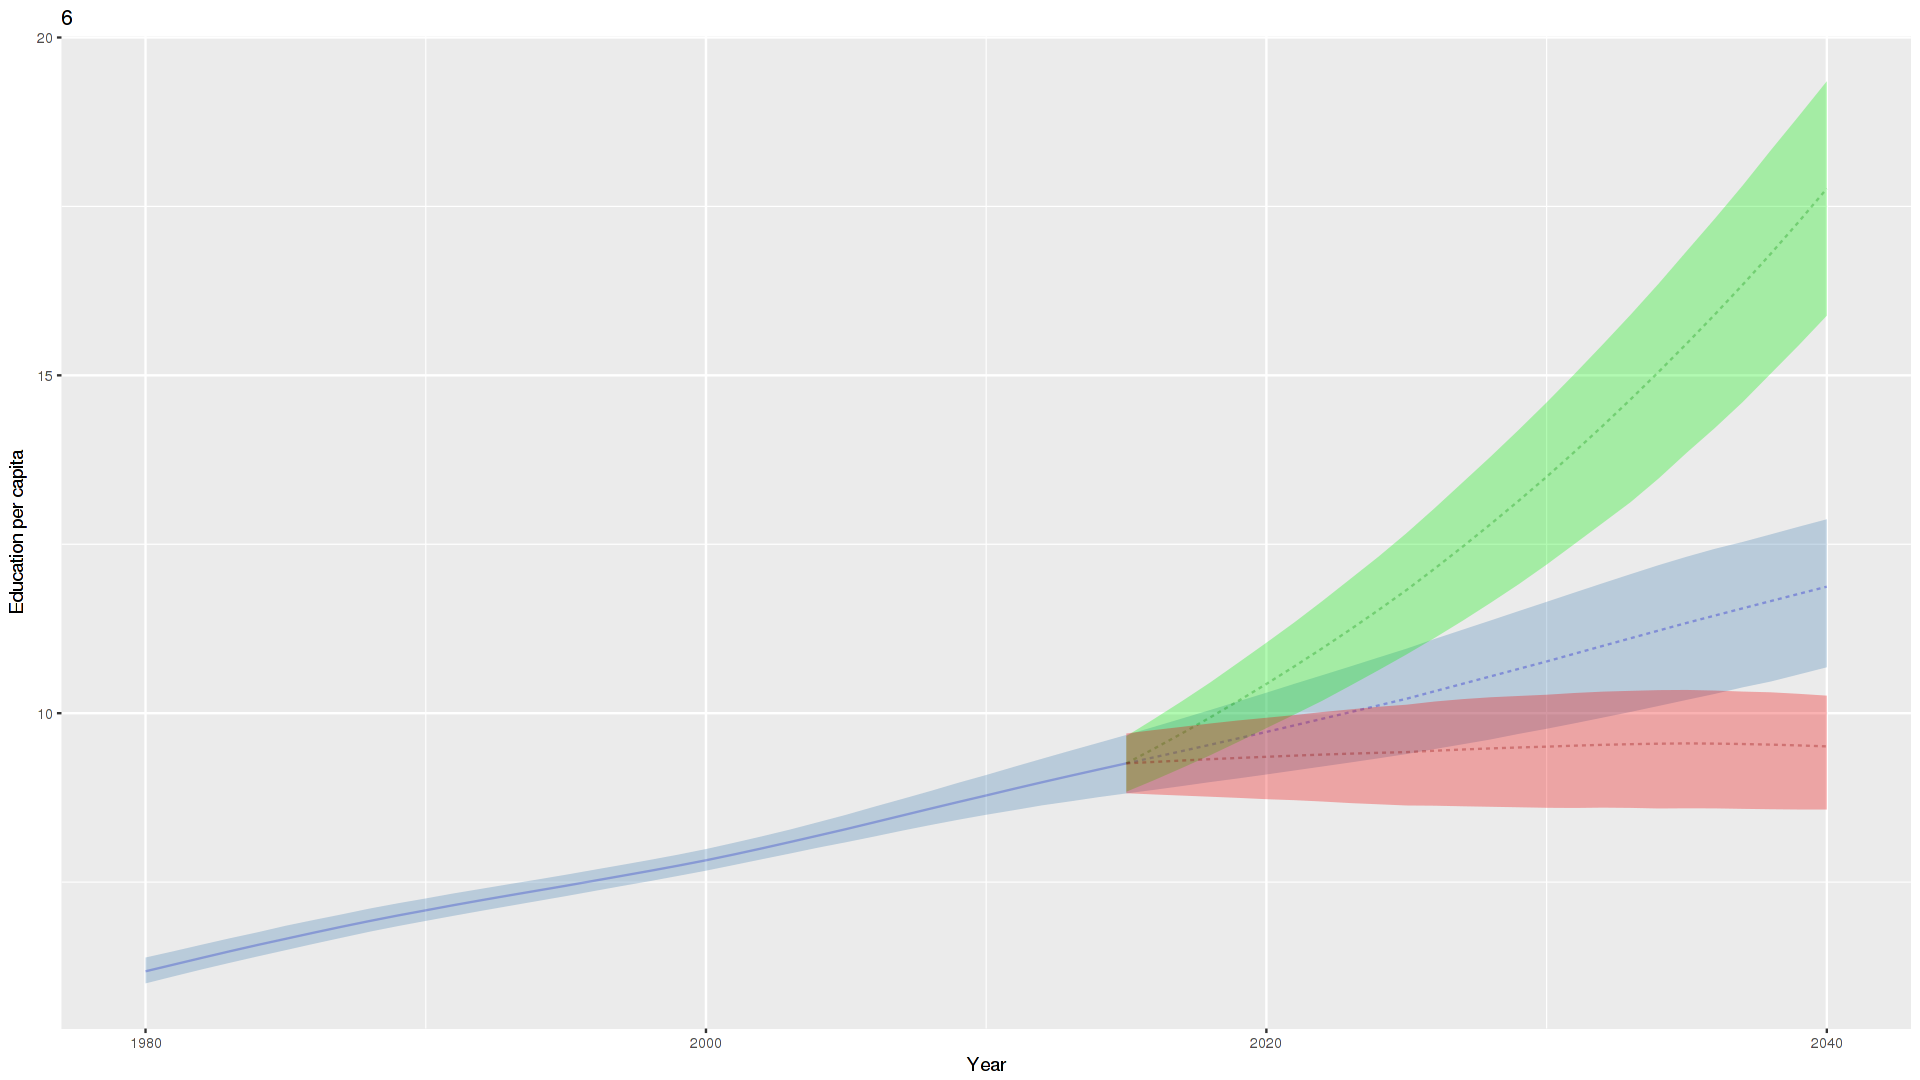

In [111]:
## Correlated
plot_country_collapsed(6, data_ref = edu_ref_corr_CY[["stats"]],
                      data_pes = edu_pes_corr_CY[["stats"]], data_opt=edu_opt_corr_CY[["stats"]])

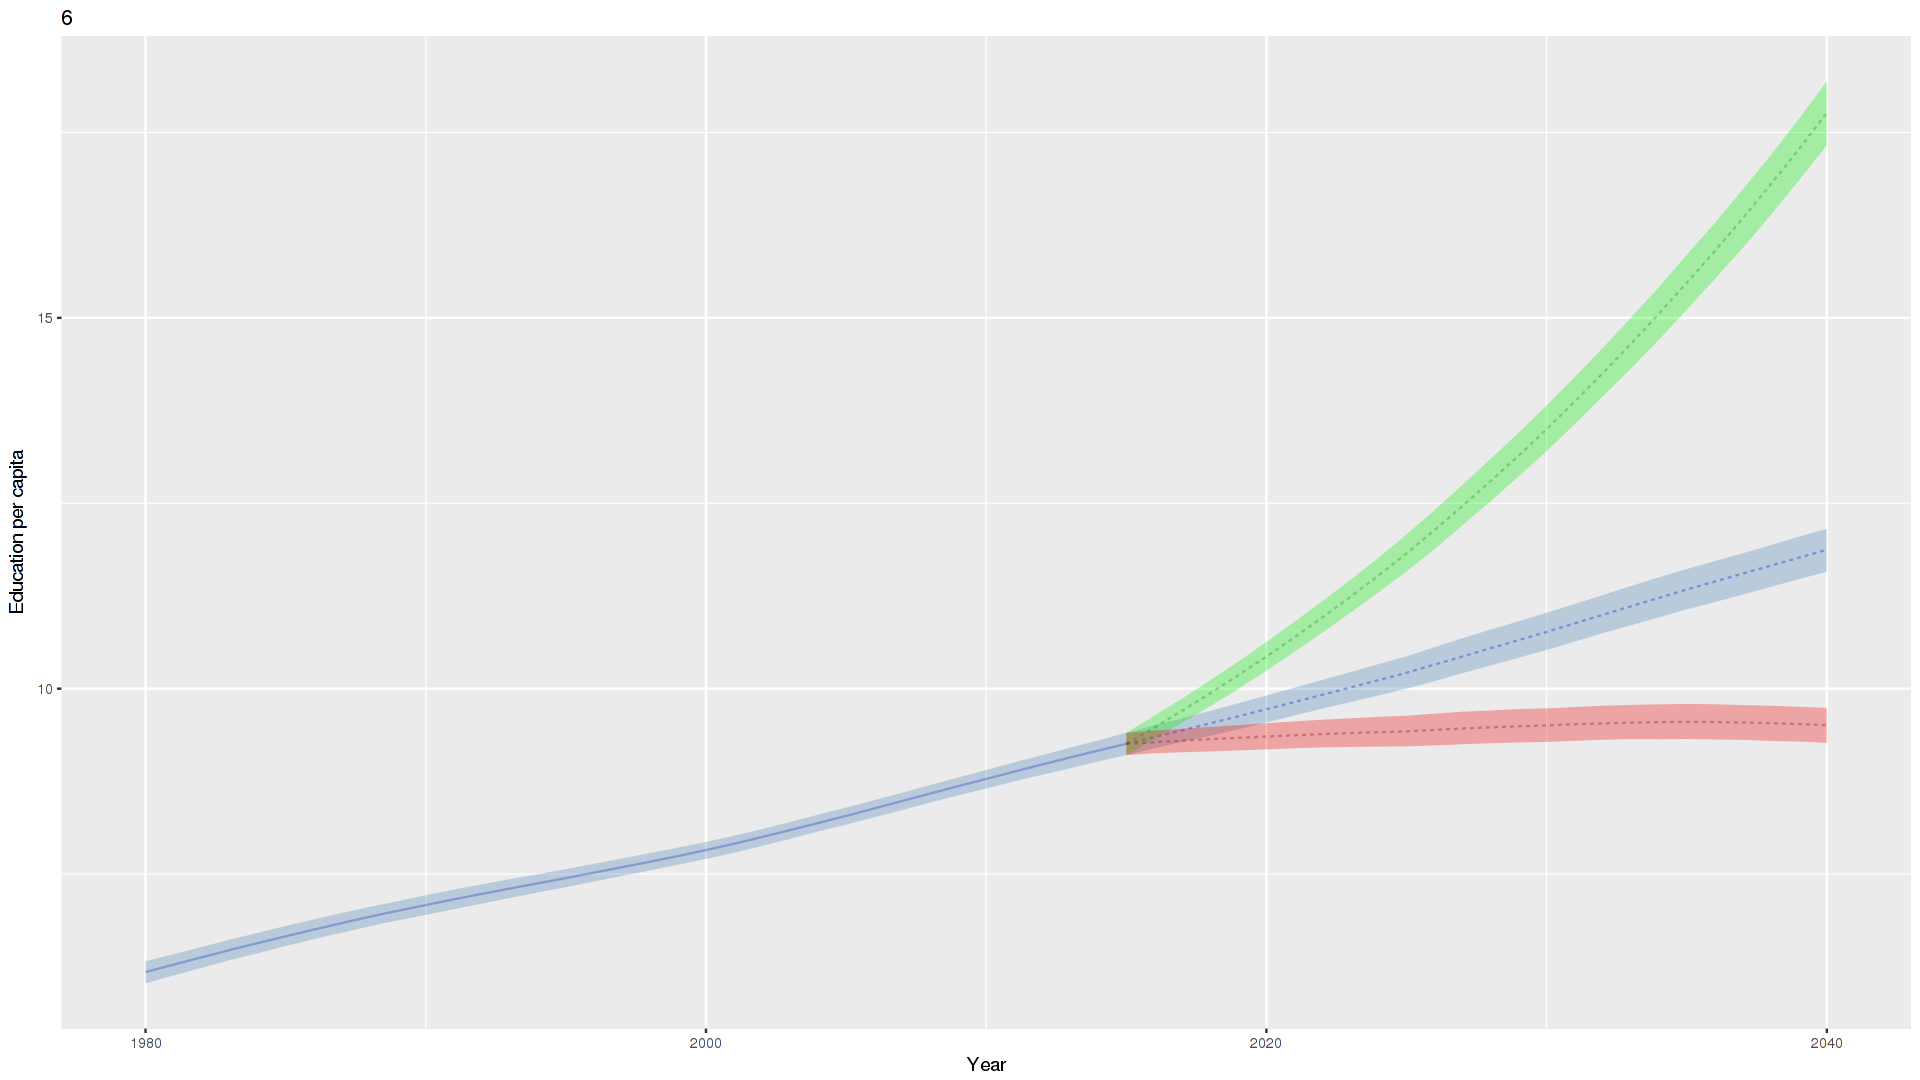

In [112]:
## Uncorrelated
plot_country_collapsed(6, data_ref = edu_ref_uncorr_CY[["stats"]],
                      data_pes = edu_pes_uncorr_CY[["stats"]], data_opt=edu_opt_uncorr_CY[["stats"]])

In [113]:
## Prep for saving out the data (merge in the stats AND add a column of scenarios)
reference_save <- merge(edu_ref_corr_CY[["draws"]], edu_ref_corr_CY[["stats"]], by = c("location_id", "year_id"))
reference_save[, scenario:= 0]

pessimistic_save <- merge(edu_pes_corr_CY[["draws"]], edu_pes_corr_CY[["stats"]], by = c("location_id", "year_id"))
pessimistic_save[, scenario:= -1]

optimistic_save <- merge(edu_opt_corr_CY[["draws"]], edu_opt_corr_CY[["stats"]], by = c("location_id", "year_id"))
optimistic_save[, scenario:= 1]

In [ ]:
## Save out data


## Reference
fwrite(reference_save, paste0(
       "/ihme/forecasting/data/fbd_scenarios_data/forecast/covariate/education/20170608_GBD2016Final/correlated_CY_edu/",
          "20170608_GBD2016Final_gpr_draws_scenario0_corr_CY.csv"))

## Pessimistic
fwrite(pessimistic_save, paste0(
       "/ihme/forecasting/data/fbd_scenarios_data/forecast/covariate/education/20170608_GBD2016Final/correlated_CY_edu/",
          "20170608_GBD2016Final_gpr_draws_scenario-1_corr_CY.csv"))

## Optimistic
fwrite(optimistic_save, paste0(
       "/ihme/forecasting/data/fbd_scenarios_data/forecast/covariate/education/20170608_GBD2016Final/correlated_CY_edu/",
          "20170608_GBD2016Final_gpr_draws_scenario1_corr_CY.csv"))